<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/MMD_0802.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random
np.random.seed(1337)

In [7]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [3]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2260701, 151)


In [4]:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)

df_accepted = df_accepted.dropna()

cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)

cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])

df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])

X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns


Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


2010
2011
2012
2013
2014
2015
2016
2017
2018


In [5]:
ML = {}
scaler = MinMaxScaler()

MODEL_TYPE = 'DL'  ## RF / DL

def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

from sklearn.ensemble import RandomForestClassifier

def build_model_rf(year,x,y,epochs=5):
    X_train= scaler.fit_transform(x)
    y_train = y #get_one_hot(y,2)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(X_train,y_train)
    return model

import os.path 

def build_model_dl(year,x,y,epochs=100):
    #X_train, X_test, y_train, y_test = train_test_split(X[year], Y[year], test_size=0.2, random_state=42)
    X_train= scaler.fit_transform(x)
    #X_test = scaler.transform(X_test)
    y_train = get_one_hot(y,2)

    # building the model
    model = Sequential()
    model.add(Dense(units=78,activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=19,activation='relu'))
    model.add(Dense(units=8,activation='relu'))
    model.add(Dense(units=4,activation='relu'))
    model.add(Dense(units=2,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    weight_path = '/content/drive/MyDrive/Drift/model/ml_'+str(year)
    if os.path.exists(weight_path+'.index'):
        model.load_weights(weight_path)
        print('load weights from ',weight_path)
    else:
        model.fit(x=X_train, 
                y=y_train, 
                epochs=epochs,
                batch_size=512,
                verbose=1)
            #validation_data=(X_test, y_test), verbose=1)
        if year > 2000:
            model.save_weights(weight_path) 
            print('save weights to ',weight_path)
    return model

In [20]:
seed_everything()

offset = int(Y[2010].shape[0] * 0.7)
y_ref = Y[2010][0:offset]
x_ref = X[2010][0:offset]
y_inf = Y[2010][offset:]
x_inf = X[2010][offset:]

ML[2010] = build_model_dl(year,x_ref,y_ref,epochs=1000)


load weights from  /content/drive/MyDrive/Drift/model/ml_2018


In [24]:
from sklearn.metrics import precision_recall_fscore_support

def predict(x):
    return np.asarray([0 if r[0] > 0.5 else 1 for r in ML[2010].predict(scaler.transform(x))])
    #return ML[2010].predict(scaler.transform(x))

base_score = precision_recall_fscore_support(y_inf, predict(x_inf) ,average='binary')
base_score

(0.942577626541897, 0.7345044746436857, 0.8256333830104322, None)

In [11]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))

print("trainset:",X[2010].shape)
print("online dataset:",X2.shape)

trainset: (11497, 81)
online dataset: (1268183, 81)


In [12]:
from scipy import stats
import sys
import math
if sys.version_info >= (3, 5):
    from math import gcd
else:
    from fractions import gcd

from scipy.stats import ks_2samp, kstest
import statsmodels.api as sm # import statsmodels 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import random
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
!pip install alibi-detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 390 kB 8.1 MB/s 
     |████████████████████████████████| 3.3 MB 75.0 MB/s 
     |████████████████████████████████| 4.7 MB 47.7 MB/s 
     |████████████████████████████████| 34.5 MB 1.4 MB/s 
     |████████████████████████████████| 596 kB 85.1 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 86.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.0
    Uninstalling llvmlite-0.39.0:
      Successfully uninstalled llvmlite-0.39.0
  Attempting uninstall: numba
    Found existing installation: numba 0.56.0
    Uninstalling numba-0.56.0:
      Successfully uninstalled numba-0.56.0


In [21]:
from alibi_detect.cd import ClassifierUncertaintyDrift, RegressorUncertaintyDrift
clf =  ML[2010].predict # tensorflow classifier model
cd = ClassifierUncertaintyDrift(
  x_ref, model=clf, backend='tensorflow', p_val=0.05, preds_type='probs'
)

0.9378105706971842 0.0 1.0
0.9462298165856717 0.0 1.0
0.9545831261395658 0.0 1.0
0.9519004372687521 0.0 1.0
0.9531223267750214 0.0 1.0
0.9538408542886669 0.0 1.0
0.958815745947734 0.0 1.0
0.9635310156782549 0.0 1.0
0.9644281914893617 0.0 1.0
0.9587973273942093 0.0 1.0
0.9609362644314408 0.0 1.0
0.9569117411500881 0.0 1.0
0.9588292055323255 0.0 1.0
0.9570760045183153 0.0 1.0
0.9566984523995623 0.0 1.0
0.9598840019333011 0.0 1.0
0.9617363344051447 0.0 1.0
0.9646529562982005 0.0 1.0
0.9624502784407319 0.0 1.0
0.9674493927125506 0.0 1.0
0.9604813790860303 0.0 1.0
0.9633575464083939 0.0 1.0
0.9639508567733592 0.0 1.0
0.9606741573033708 0.0 1.0
0.965769358590894 0.0 1.0
0.9601257445400397 0.0 1.0
0.9636152184748297 0.0 1.0
0.9622199933132731 0.0 1.0
0.9652596838631231 0.0 1.0
0.9608428446005268 0.0 1.0
0.962257432793306 0.0 1.0
0.9673167208378476 0.0 1.0
0.9700577832253546 0.0 1.0
0.9673419490045407 0.0 1.0
0.962466960352423 0.0 1.0
0.9638260869565217 0.0 1.0
0.9617132867132867 0.0 1.0
0.959

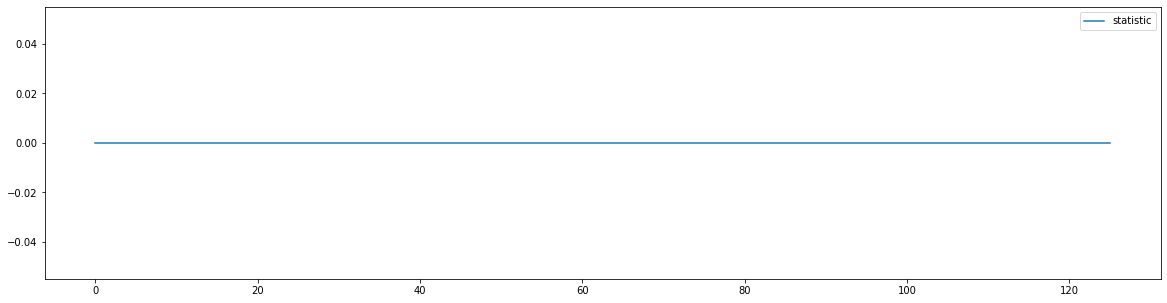

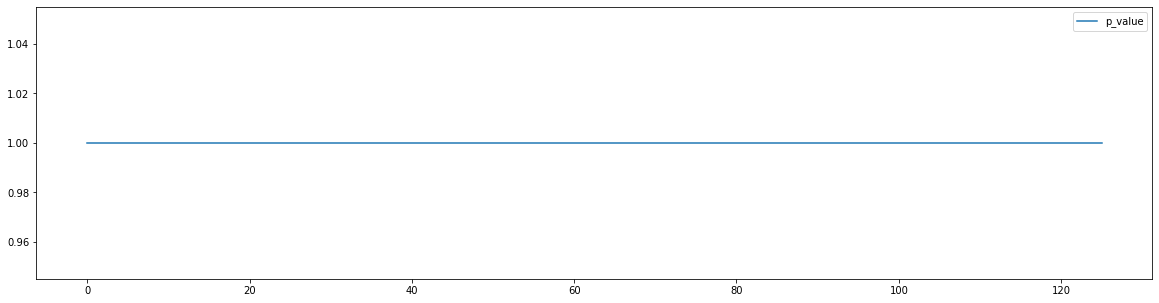

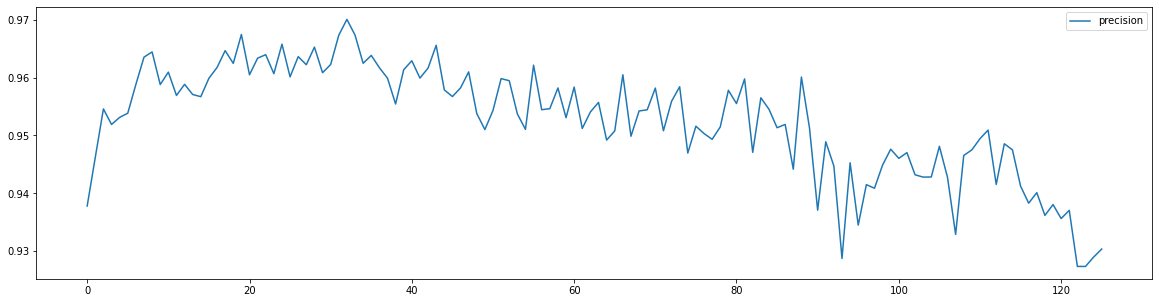

In [28]:


df = {}

drift_d = []
df['precision'] = []
df['statistic'] = []
df['p_value'] = []
#df['dd_cad_statistic'] = []
#df['dd_cad_p_value'] = []

beta = 0
window_size = 10000
step = 10000
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    f1 = precision_recall_fscore_support(uy, predict(ux),average='binary')

    df['precision'].append(f1[0])

    preds = cd.predict(ux)
    p = preds['data']['p_val'][0]
    d = preds['data']['distance'][0]
    df['p_value'].append(p)    
    df['statistic'].append(d)
    print(f1[0],d,p)

df2 = pd.DataFrame(df)

df2['statistic'].plot(legend=True,figsize=(20,5))
plt.show()
df2['p_value'].plot(legend=True,figsize=(20,5))
plt.show()
df2['precision'].plot(legend=True,figsize=(20,5))
plt.show()

In [ ]:
del df['dd_cad_statistic']
del df['dd_cad_p_value']
df2 = pd.DataFrame(df)



In [ ]:
df2['dd_mmd_statistic'].plot(legend=True,figsize=(20,5))
plt.show()
df2['dd_mmd_p_value'].plot(legend=True,figsize=(20,5))
plt.show()
df2['precision'].plot(legend=True,figsize=(20,5))
plt.show()